# PCA for PF Construction

In [1]:
!pip install yfinance


[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
from sklearn.decomposition import PCA
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


2025-03-19 13:03:11.612827: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 13:03:11.624837: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 13:03:11.721979: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-19 13:03:11.819865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742389391.893329  681639 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742389391.91

In [84]:
from data_querry import  fetch_ftse100_all_components,fetch_ftse100_index
data = fetch_ftse100_all_components()
index_data=fetch_ftse100_index()
data=data.merge(index_data,on='date')

ModuleNotFoundError: No module named 'data_querry'

In [ ]:
df=data.copy()

In [ ]:
df.set_index('date', inplace=True)

df.fillna(method='ffill', inplace=True)


In [ ]:
df.isna().sum()

In [ ]:
df

In [ ]:
# Create log returns to remove stationarity
log_returns = np.log(df / df.shift(1))

# Drop NaN values caused by the shift
log_returns = log_returns.dropna().drop(columns="FTSE100")

In [ ]:
# Creating X of the closing prices (absolute prices)
X_abs = df.drop(columns="FTSE100").dropna()
stock_features = X_abs.columns
X_abs.shape

In [ ]:
# Creating X of the closing prices (log returns)
X_log = log_returns.copy()
stock_log_features = X_log.columns
X_log.shape

In [ ]:
# Preprocessing ABS (data must be centered around its mean before PCA)
scaler = StandardScaler()
scaler.fit(X_abs)
X_abs = pd.DataFrame(scaler.transform(X_abs), columns=stock_features)
X_abs

In [ ]:
# Preprocessing LOG (data must be centered around its mean before PCA)
scaler.fit(X_log)
X_log = pd.DataFrame(scaler.transform(X_log), columns=stock_log_features, index=log_returns.index)
X_log

In [ ]:
# Compute Principal Components
pca = PCA()
pca.fit(X_abs)

In [ ]:
# Access PCs
W = pca.components_
# Print PCs as COLUMNS
T = pd.DataFrame(W.T,
                 index=stock_features,
                 columns=[f'PC{i}' for i in range(1, pca.n_components_+1)])
T

In [ ]:
# Compute Principal Components log returns
pca2 = PCA()
pca2.fit(X_log)

In [ ]:
# Access PCs
W2 = pca2.components_
# Print PCs as COLUMNS
T_log = pd.DataFrame(W2.T,
                 index=stock_log_features,
                 columns=[f'PC{i}' for i in range(1, pca2.n_components_+1)])
T_log

In [ ]:
# pca.explained_variance_ratio_ and pca2.explained_variance_ratio_ (absolute vs log return)
explained_variance_1 = pca.explained_variance_ratio_
explained_variance_2 = pca2.explained_variance_ratio_

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first PCA - abs
axes[0].plot(explained_variance_1)
axes[0].set_title('PCA 1 - Explained Variance using abs prices')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('% Explained Variance')

# Plot the second PCA - log
axes[1].plot(explained_variance_2)
axes[1].set_title('PCA 2 - Explained Variance using log return')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('% Explained Variance')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# first PCA - ABS
axes[0].plot(np.cumsum(explained_variance_1))
axes[0].set_title('cumulated share of explained variance using stock prices')
axes[0].set_xlabel('# of principal component used')

# second PCA - log
axes[1].plot(np.cumsum(explained_variance_2))
axes[1].set_title('cumulated share of explained variance using log return')
axes[1].set_xlabel('# of principal component used')

# Adjust the y-axis scale
axes[0].set_ylim(0.4, 1.0)  # Adjust scale for subplot 1
axes[1].set_ylim(0.2, 1.0)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Picking stocks most closely mimicking the index (based on log returns method)

# Keeping only PC1 and PC2
T_log = T_log.iloc[:, :4]

# adding column showing cum PC1+PC2
T_log["PC_sum"] = T_log["PC1"]+T_log["PC2"]+T_log["PC3"]+T_log["PC4"]

# Sort by PC_sum
T_log_sorted = T_log.sort_values("PC_sum", ascending=False)
T_log_sorted = T_log_sorted.reset_index()
T_log_sorted.rename(columns={T_log_sorted.columns[0]: "Stocks" }, inplace = True)

# Calculate the sum of 'PC_sum' for the top 5 rows
top_5_sum = T_log_sorted["PC_sum"].head(5).sum()

# Add the 'pf_weights' column by dividing each stock's 'PC_sum' by the top 5 sum
T_log_sorted["pf_weights"] = T_log_sorted["PC_sum"] /top_5_sum
# Set weights to 0 for rows beyond the top 5
T_log_sorted.loc[5:, "pf_weights"] = 0

T_log_sorted.head(10)

In [ ]:
import matplotlib.dates as mdates
# Index the data by dividing each stock's prices by its first value
indexed_data = df / df.iloc[0] * 100

# Retrieve the top 5 stocks from the "Stocks" column of T_log_sorted
top_5_stocks = T_log_sorted["Stocks"].head(5)

# Plot the FTSE index
plt.plot(indexed_data["FTSE100"], label="FTSE100", linewidth=2)

# Plot each of the top 5 stocks dynamically
for stock in top_5_stocks:
    if stock in indexed_data.columns:  # Ensure the stock is in the data
        plt.plot(indexed_data[stock], label=stock)

# Add a legend to distinguish the lines
plt.legend()

# Format the dates on the x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show dates every 1 month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Month Year"

# Add titles and labels
plt.title("Indexed Closing Prices of Top 5 Stocks and FTSE")
plt.xlabel("Time")
plt.ylabel("Indexed Price (Base = 100)")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Extract the top 5 stocks and their weights to make a replicating portfolio
top_5_stocks = T_log_sorted["Stocks"].head(5)
top_5_weights = T_log_sorted["pf_weights"].head(5)

# Calculate the weighted sumproduct (dot product of weights and indexed returns)
weighted_returns = (indexed_data[top_5_stocks] * top_5_weights.values).sum(axis=1)

# Plot the weighted returns
plt.plot(weighted_returns, label="Synthetic Portfolio", color="blue", linewidth=2)

# Plot the FTSE index for comparison
plt.plot(indexed_data["FTSE100"], label="FTSE", color="orange", linestyle="--")

# Add legend, labels, and title
plt.legend()
plt.title("Synthetic Portfolio vs FTSE Index")
plt.xlabel("Time")
plt.ylabel("Weighted Indexed Returns")
plt.xticks(rotation=45)

# Show the plot

In [ ]:
window = 100 # n of trading days
dates = X_log.index[window:]  # Align dates with the end of each rolling window

# Placeholder for summed PCs for all stocks (full data)
summed_pcs_full = {}

def rolling_pca(window_start):
    pca_roll = PCA()
    # Create the rolling window data excluding today's data
    window_data = X_log.iloc[window_start:window_start + window - 1, :]  # Exclude today's row
    # Fit PCA to the rolling window
    pca_roll.fit(window_data)
    # Extract loadings (components matrix)
    loadings_matrix = pca_roll.components_.T  # Transpose to get stocks as rows

    # Sum the first 4 PCs for each stock
    summed_values = loadings_matrix[:, :4].sum(axis=1)  # Sum across the first 4 PCs
    summed_pcs_full[dates[window_start]] = pd.Series(summed_values, index=X_log.columns)  # Store as Series

# Iterate through rolling windows
for start in range(len(X_log) - window):
    rolling_pca(start)

# Combine results into a full DataFrame (dates as rows, stocks as columns)
summed_pcs_full_df = pd.DataFrame(summed_pcs_full).T  # Transpose to align dates as rows
summed_pcs_full_df.index.name = "Date"  # Set index name

In [ ]:
# Placeholder for daily portfolio weights
daily_portfolio = []

# Loop through each date
for date in summed_pcs_full_df.index:
    # Get summed PCs for all stocks on this date
    daily_values = summed_pcs_full_df.loc[date]

    # Select the top 10 stocks for this date
    top10_stocks = daily_values.nlargest(10)  # Top 10 stocks by summed PCs

    # Normalize the summed PCs to use as portfolio weights
    portfolio_weights = top10_stocks / top10_stocks.sum()  # calc weights

    # Store the portfolio details (date, stocks, weights)
    portfolio_details = {
        "Date": date,
        "Stocks": list(top10_stocks.index),
        "Weights": list(portfolio_weights.values)
    }
    daily_portfolio.append(portfolio_details)

# Convert to a structured DataFrame
daily_portfolio_df = pd.DataFrame(daily_portfolio)

print("Daily Portfolio with Stocks and Weights:")
print(daily_portfolio_df.head(10))


In [ ]:
daily_portfolio_df

In [ ]:
# Placeholder for daily weights across all stocks
daily_weights = []

# Loop through each date in the summed PCs DataFrame
for date in summed_pcs_full_df.index:
    # Get summed PCs for all stocks on this date
    daily_values = summed_pcs_full_df.loc[date]

    # Select the top 10 stocks for this date
    top10_stocks = daily_values.nlargest(10)  # Top 10 stocks by summed PCs

    # calc stock weights
    portfolio_weights = top10_stocks / top10_stocks.sum()

    # Create a row of weights with 0 for stocks not in the top 10
    row_weights = pd.Series(0.0, index=summed_pcs_full_df.columns)  # Initialize with zeros
    row_weights[top10_stocks.index] = portfolio_weights

    # Add the row of weights to the daily weights list
    daily_weights.append(row_weights)

# Create df
daily_weights_df = pd.DataFrame(daily_weights, index=summed_pcs_full_df.index)

print("Daily Weights Matrix (All Stocks, Top 10 Weighted):")
print(daily_weights_df.head(10))

In [ ]:
daily_weights_df

In [ ]:
pca_date = '2024-03-07'

# Filter stocks with values > 0 on the specific date
filtered_columns = daily_weights_df.loc[pca_date][daily_weights_df.loc[pca_date] > 0].index
rep_pf = daily_weights_df.loc[[pca_date], filtered_columns]

In [115]:
rep_pf

source_file,AHT,DPLM,EXPN,FCIT,HLMA,IMI,ITRK,REL,SGE,SMT
Date,,,,,,,,,,
2024-03-07,0.080422,0.083545,0.152897,0.088149,0.091739,0.086047,0.083673,0.1245,0.127793,0.081235


In [116]:
rep_pf_log_returns_daily = log_returns[rep_pf.columns]

In [117]:
rep_pf_log_returns_daily

source_file,AHT,DPLM,EXPN,FCIT,HLMA,IMI,ITRK,REL,SGE,SMT
date,,,,,,,,,,
2022-07-18,0.018615,0.006656,0.007252,0.001207,-0.004268,-0.008217,0.002059,-0.006512,0.015421,0.021756
2022-07-19,0.008925,0.017263,0.004326,0.001206,0.016966,0.032470,0.003878,0.006512,-0.004720,0.001001
2022-07-20,0.033698,0.042288,-0.007583,0.017911,0.017142,0.003986,-0.001139,0.001729,0.021645,0.046645
2022-07-21,0.016795,0.052503,0.027174,0.015267,0.031648,0.027463,0.027652,0.015856,0.018349,0.014920
2022-07-22,0.011042,0.005913,-0.000353,0.005811,0.015456,-0.005433,0.001551,0.002548,-0.005127,-0.023066
...,...,...,...,...,...,...,...,...,...,...
2025-03-04,-0.085894,-0.021139,-0.007469,-0.030117,-0.008985,-0.053478,0.043650,-0.001828,-0.021633,-0.063894
2025-03-05,0.027325,0.000909,-0.014020,0.005381,0.008627,0.037929,-0.025389,-0.020603,-0.001592,0.026652
2025-03-06,0.010768,-0.015561,-0.018083,0.001787,-0.026475,0.003910,-0.007648,-0.021854,-0.027454,0.003807


In [118]:
# to show replication backwards, not backtest
rep_pf_results = rep_pf_log_returns_daily.loc[:pca_date].mul(rep_pf.iloc[0], axis=1)
rep_pf_results["total_rep_pf"] = rep_pf_results.sum(axis=1)
rep_pf_results

source_file,AHT,DPLM,EXPN,FCIT,HLMA,IMI,ITRK,REL,SGE,SMT,total_rep_pf
date,,,,,,,,,,,
2022-07-18,0.001497,0.000556,0.001109,0.000106,-0.000392,-0.000707,0.000172,-0.000811,0.001971,0.001767,0.005269
2022-07-19,0.000718,0.001442,0.000661,0.000106,0.001556,0.002794,0.000325,0.000811,-0.000603,0.000081,0.007891
2022-07-20,0.002710,0.003533,-0.001159,0.001579,0.001573,0.000343,-0.000095,0.000215,0.002766,0.003789,0.015253
2022-07-21,0.001351,0.004386,0.004155,0.001346,0.002903,0.002363,0.002314,0.001974,0.002345,0.001212,0.024349
2022-07-22,0.000888,0.000494,-0.000054,0.000512,0.001418,-0.000467,0.000130,0.000317,-0.000655,-0.001874,0.000709
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,0.000592,0.000626,-0.001224,0.000537,0.000000,-0.000348,-0.000618,-0.001812,0.000000,0.000787,-0.001460
2024-03-04,0.000084,-0.001257,0.000091,-0.000537,-0.000120,0.000497,0.000600,-0.000037,0.000921,-0.000706,-0.000463
2024-03-05,-0.007901,-0.001177,-0.000547,-0.000360,-0.000761,-0.001198,0.004991,0.000365,-0.001900,-0.001823,-0.010313


In [119]:
# Calculate log returns FTSE100
FTSE_log_return = np.log(df["FTSE100"] / df["FTSE100"].shift(1)).loc[:pca_date]


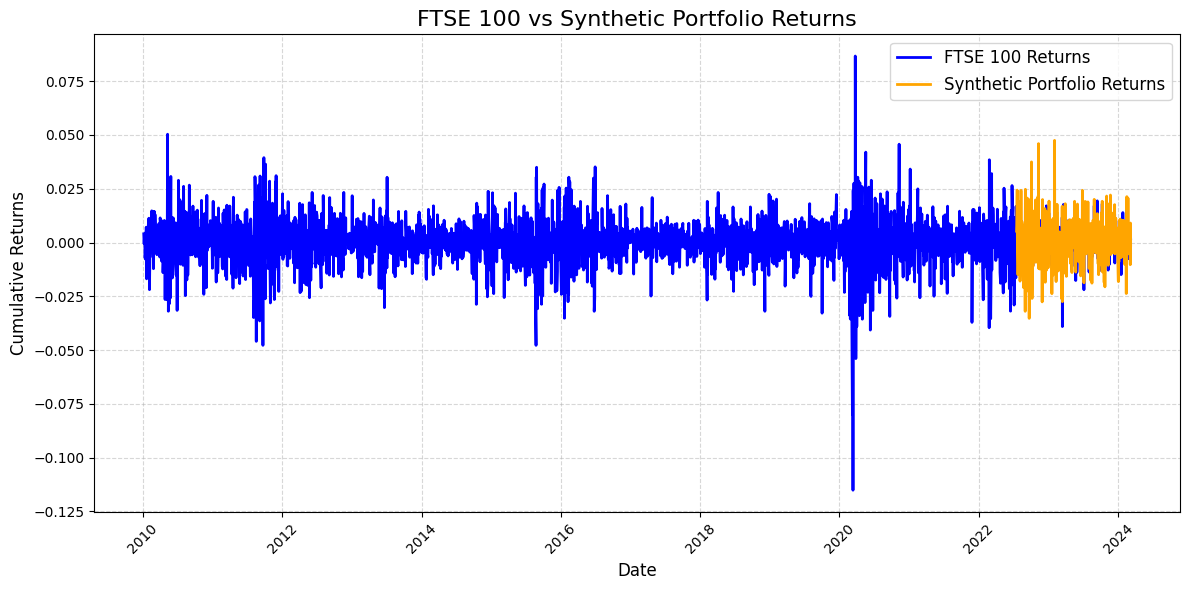

In [120]:
# Assuming FTSE_return and rep_pf_results["total_rep_pf"] are pandas Series with datetime indices
plt.figure(figsize=(12, 6))

# Plot FTSE returns
plt.plot(FTSE_log_return, label="FTSE 100 Returns", color="blue", linewidth=2)

# Plot Synthetic Portfolio returns
plt.plot(rep_pf_results["total_rep_pf"], label="Synthetic Portfolio Returns", color="orange", linewidth=2)

# Add grid
plt.grid(True, linestyle='--', alpha=0.5)

# Add title and labels
plt.title("FTSE 100 vs Synthetic Portfolio Returns", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)

# Format x-axis for dates
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Add a legend
plt.legend(fontsize=12)

# Show the plot
plt.show()


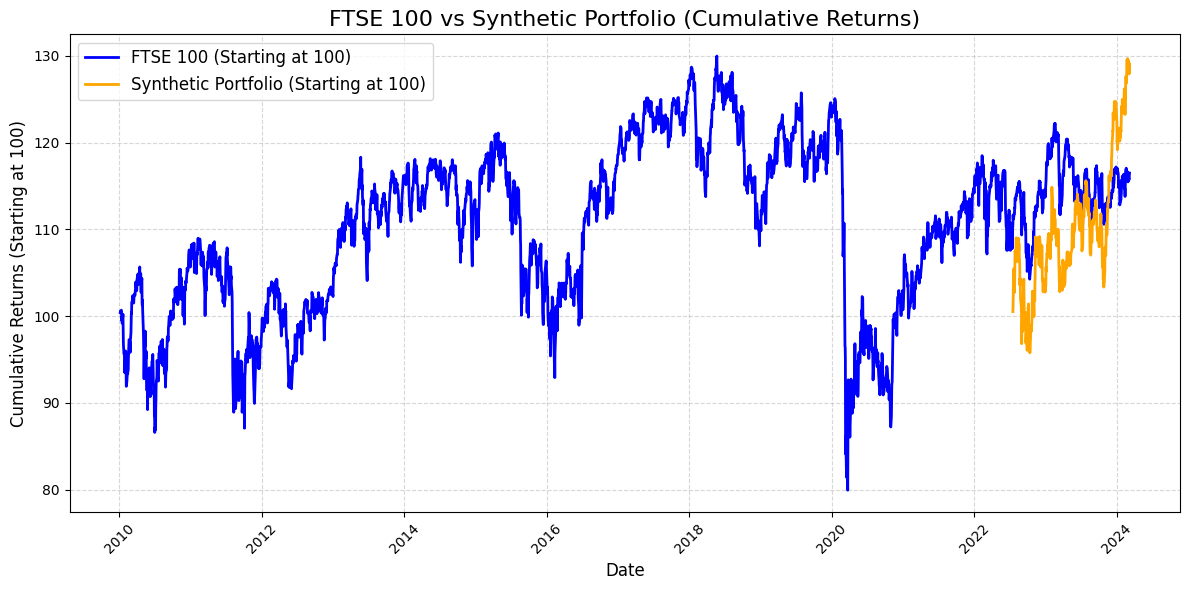

In [121]:
# Convert daily returns to cumulative returns starting at 100
FTSE_cumulative = (FTSE_log_return + 1).cumprod() * 100  # Convert to cumulative returns
rep_pf_cumulative = (rep_pf_results["total_rep_pf"] + 1).cumprod() * 100  # Convert to cumulative returns

# Plot the cumulative returns
plt.figure(figsize=(12, 6))

# Plot FTSE cumulative returns
plt.plot(FTSE_cumulative, label="FTSE 100 (Starting at 100)", color="blue", linewidth=2)

# Plot Synthetic Portfolio cumulative returns
plt.plot(rep_pf_cumulative, label="Synthetic Portfolio (Starting at 100)", color="orange", linewidth=2)

# Add grid
plt.grid(True, linestyle='--', alpha=0.5)

# Add title and labels
plt.title("FTSE 100 vs Synthetic Portfolio (Cumulative Returns)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns (Starting at 100)", fontsize=12)

# Format x-axis for dates
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Add a legend
plt.legend(fontsize=12)

# Show the plot
plt.show()


In [122]:
FTSE_cumulative

date
2010-01-04           NaN
2010-01-05    100.402806
2010-01-06    100.539068
2010-01-07    100.479058
2010-01-08    100.615320
                 ...    
2024-03-01    116.341755
2024-03-04    115.700924
2024-03-05    115.790243
2024-03-06    116.290405
2024-03-07    116.490128
Name: FTSE100, Length: 3594, dtype: float64

In [123]:
rep_pf_cumulative

date
2022-07-18    100.526932
2022-07-19    101.320235
2022-07-20    102.865702
2022-07-21    105.370374
2022-07-22    105.445055
                 ...    
2024-03-01    129.316757
2024-03-04    129.256861
2024-03-05    127.923849
2024-03-06    129.081150
2024-03-07    128.927332
Name: total_rep_pf, Length: 418, dtype: float64

In [124]:
spread_df = pd.merge(rep_pf_cumulative, FTSE_cumulative, on='date', how='inner') 
spread_df["spread"] = spread_df["FTSE100"] - spread_df["total_rep_pf"]
spread_df

,total_rep_pf,FTSE100,spread
date,,,
2022-07-18,100.526932,110.557411,10.030478
2022-07-19,101.320235,111.670641,10.350406
2022-07-20,102.865702,111.179800,8.314098
2022-07-21,105.370374,111.274653,5.904280
2022-07-22,105.445055,111.364914,5.919859
...,...,...,...
2024-03-01,129.316757,116.341755,-12.975003
2024-03-04,129.256861,115.700924,-13.555937
2024-03-05,127.923849,115.790243,-12.133607


In [125]:
#long if z score = less - 0.5     but not smaller than - 2   ;   short if over 0.5 but less then 2

In [126]:
# Backtesting : calculate z score on rolling basis of past 60 days (t 1 is the pca input, and then calc returns post t1 based on z score strategy)    -1: short rep, long ftse



# Predicting Spread with LSTM / NN

In [127]:
def get_economic_indicators(start_date, end_date):
    tickers = [
        "^GSPC",   # S&P 500
        "^VIX",    # Volatility Index
        "^TNX",    # 10-Year Treasury Yield
        "^FVX",    # 5-Year Treasury Yield
        "GC=F",    # Gold Futures
        "CL=F",    # Crude Oil Futures
        "GBPUSD=X" # GBP/USD Exchange Rate
    ]
    
    data = yf.download(tickers, start=start_date, end=end_date)
    data = data['Close']    
    return data


In [128]:
economic_indicators = get_economic_indicators('2022-01-31', '2025-03-14')

[*********************100%***********************]  7 of 7 completed


In [129]:
abstickers = {
        "^GSPC":"SP500",   
        "^VIX":"VIX",    
        "^TNX":"TNX",    
        "^FVX":"FVX",      
        "GC=F":"GF",    
        "CL=F":"COF",   
        "GBPUSD=X":"GBPUSD" 
}

In [6]:
from data_query  import eco_df
bg_data=eco_df()

In [7]:
eco_df

Ticker,COF,GBPUSD,GF,FVX,SP500,TNX,VIX
Date,,,,,,,
2022-01-31,88.150002,1.340339,1795.000000,1.614,4515.549805,1.782,24.830000
2022-02-01,88.199997,1.344538,1800.300049,1.624,4546.540039,1.800,21.959999
2022-02-02,88.260002,1.352539,1809.199951,1.600,4589.379883,1.766,22.090000
2022-02-03,90.269997,1.356502,1803.000000,1.661,4477.439941,1.827,24.350000
2022-02-04,92.309998,1.359841,1806.599976,1.788,4500.529785,1.930,23.219999
...,...,...,...,...,...,...,...
2025-03-07,67.040001,1.288530,2904.699951,4.093,5770.200195,4.317,23.370001
2025-03-10,66.029999,1.293243,2891.000000,3.974,5614.560059,4.213,27.860001
2025-03-11,66.250000,1.287548,2912.899902,4.042,5572.069824,4.288,26.920000


In [8]:
eco_df.isna().sum()

Date       0
COF       30
GBPUSD     0
GF        30
FVX       31
SP500     31
TNX       31
VIX       31
dtype: int64

In [133]:
eco_df.fillna(method='ffill', inplace=True)


/tmp/ipykernel_518556/3995343485.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eco_df.fillna(method='ffill', inplace=True)


In [134]:


def convert_to_log_returns(data):
    log_returns = data.copy()
    
    # List of indicators to convert to log returns
    convert_tickers = ['SP500', 'GF', 'COF', 'GBPUSD']
    
    # Apply log returns conversion
    for ticker in convert_tickers:
        if ticker in log_returns.columns:
            log_returns[ticker] = np.log(log_returns[ticker] / log_returns[ticker].shift(1))
    
    # Drop the first row which will have NaN values due to the shift
    log_returns = log_returns.dropna()
    
    return log_returns

log_return_eco = convert_to_log_returns(eco_df)

In [135]:
log_return_eco

Ticker,COF,GBPUSD,GF,FVX,SP500,TNX,VIX
Date,,,,,,,
2022-02-01,0.000567,0.003128,0.002948,1.624,0.006840,1.800,21.959999
2022-02-02,0.000680,0.005933,0.004931,1.600,0.009378,1.766,22.090000
2022-02-03,0.022518,0.002926,-0.003433,1.661,-0.024693,1.827,24.350000
2022-02-04,0.022347,0.002458,0.001995,1.788,0.005144,1.930,23.219999
2022-02-07,-0.010783,-0.004789,0.007719,1.765,-0.003709,1.916,22.860001
...,...,...,...,...,...,...,...
2025-03-07,0.010195,-0.000513,-0.004088,4.093,0.005505,4.317,23.370001
2025-03-10,-0.015180,0.003651,-0.004728,3.974,-0.027344,4.213,27.860001
2025-03-11,0.003326,-0.004413,0.007547,4.042,-0.007597,4.288,26.920000


In [136]:
def prepare_data_for_lstm(df, economic_indicators, sequence_length=20):
    
    merged_df = df.join(economic_indicators, how='inner')
    
    # Calculate additional features
    merged_df['volatility_ftse'] = df['FTSE100'].pct_change().rolling(window=20).std()
    merged_df['volatility_pf'] = df['total_rep_pf'].pct_change().rolling(window=20).std()
    merged_df['spread_ma5'] = df['spread'].rolling(window=5).mean()
    merged_df['spread_ma20'] = df['spread'].rolling(window=20).mean()
    
    merged_df['rsi_spread'] = calculate_rsi(df['spread'], window=14)
    merged_df = merged_df.dropna()
    
    
    features = ['SP500', 'VIX', 'TNX', 'FVX', 
                'GF', 'COF', 'GBPUSD', 'FTSE100', 'total_rep_pf',
                'volatility_ftse', 'volatility_pf', 'spread_ma5', 'spread_ma20', 'rsi_spread']
    
    target = ['spread']

    train_size = int(len(merged_df) * 0.8)
    train_data = merged_df.iloc[:train_size]
    test_data = merged_df.iloc[train_size:]

    # feature_scaler = MinMaxScaler(feature_range=(0, 1))
    # target_scaler = MinMaxScaler(feature_range=(0, 1))

    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    feature_scaler.fit(train_data[features])
    target_scaler.fit(train_data[target])
    
    train_feature_scaled = feature_scaler.transform(train_data[features])
    train_target_scaled = target_scaler.transform(train_data[target])
    
    test_feature_scaled = feature_scaler.transform(test_data[features])
    test_target_scaled = target_scaler.transform(test_data[target])
    
    X_train, y_train = create_sequences(train_feature_scaled, train_target_scaled, sequence_length)
    X_test, y_test = create_sequences(test_feature_scaled, test_target_scaled, sequence_length)
    
    
    return X_train, X_test, y_train, y_test, feature_scaler, target_scaler, train_data,test_data,merged_df,features



In [137]:
# Function to calculate RSI
def calculate_rsi(series, window=14):
    """Calculate RSI for a price series"""
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

In [138]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    
    return np.array(X_seq), np.array(y_seq)


In [139]:
def build_lstm_model(X_train, y_train, X_test, y_test):
    
    n_features = X_train.shape[2]
    
    lr=3.28920104987804e-05
    model = Sequential()
    model.add(LSTM(10, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(30, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1
    )
    
    return model, history


Epoch 1/100


/home/sb/.pyenv/versions/3.10.6/envs/stockify_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 1.0121 - val_loss: 16.1374
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.1167 - val_loss: 16.0196
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.0236 - val_loss: 15.9011
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.0065 - val_loss: 15.7671
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.9387 - val_loss: 15.6306
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.9197 - val_loss: 15.4952
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0089 - val_loss: 15.3424
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9613 - val_loss: 15.1809
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8990 - val_loss: 15.0111
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.9941 - val_loss: 14.8270
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.9565 - val_loss: 14.6334
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 

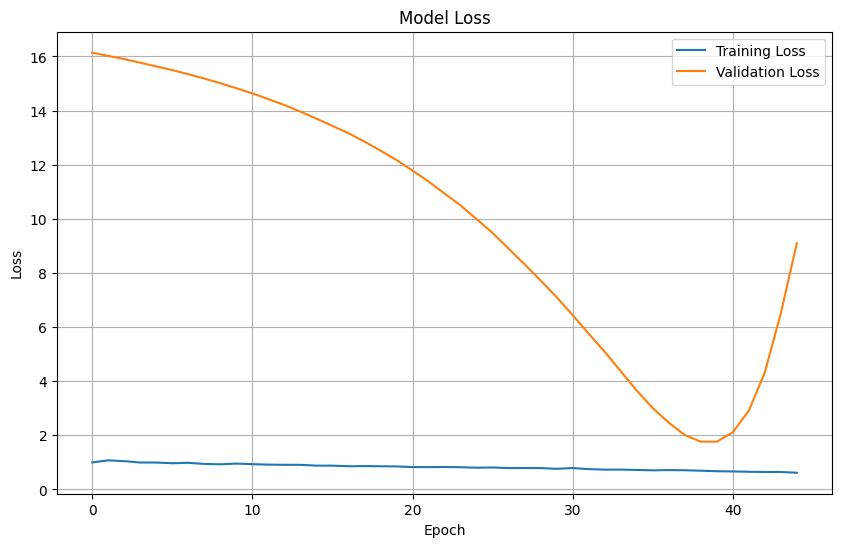

In [140]:
economic_indicators=log_return_eco
    
X_train, X_test, y_train, y_test, feature_scaler,target_scaler,train_data,test_data,merged_df,features= prepare_data_for_lstm(
   spread_df , economic_indicators, 20
)

model, history = build_lstm_model(X_train, y_train, X_test, y_test)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
    

In [141]:
sequence_length=20
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred = target_scaler.inverse_transform(train_pred)
test_pred = target_scaler.inverse_transform(test_pred)

train_indices = train_data.index[sequence_length:]
test_indices = test_data.index[sequence_length:]

train_predictions_df = pd.DataFrame(
    data=train_pred, 
    columns=['predicted_spread'],
    index=train_indices[:len(train_pred)]  # Ensure matching lengths
)
train_predictions_df['actual_spread'] = train_data.loc[train_indices[:len(train_pred)], 'spread'].values
train_predictions_df['dataset'] = 'train'

test_predictions_df = pd.DataFrame(
    data=test_pred, 
    columns=['predicted_spread'],
    index=test_indices[:len(test_pred)]  # Ensure matching lengths
)
test_predictions_df['actual_spread'] = test_data.loc[test_indices[:len(test_pred)], 'spread'].values
test_predictions_df['dataset'] = 'test'

# Combine predictions for full view
all_predictions_df = pd.concat([train_predictions_df, test_predictions_df])
all_predictions_df

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


,predicted_spread,actual_spread,dataset
2022-09-13,8.430139,11.017039,train
2022-09-14,8.738923,10.905533,train
2022-09-15,8.732064,11.149446,train
2022-09-16,8.790131,10.992478,train
2022-09-20,8.780412,11.491028,train
...,...,...,...
2024-03-01,-18.318480,-12.975003,test
2024-03-04,-16.908453,-13.555937,test
2024-03-05,-16.735220,-12.133607,test
2024-03-06,-16.732632,-12.790746,test


In [142]:
z_score_window=20
test_predictions = all_predictions_df[all_predictions_df['dataset'] == 'test'].copy()

actual_spread = test_predictions['actual_spread']
predicted_spread = test_predictions['predicted_spread']

error = actual_spread - predicted_spread

rolling_mean = error.rolling(window=z_score_window).mean()
rolling_std = error.rolling(window=z_score_window).std()
z_score = (error - rolling_mean) / rolling_std

signals = pd.DataFrame(index=test_predictions.index)
signals['actual_spread'] = actual_spread
signals['predicted_spread'] = predicted_spread
signals['error'] = error
signals['z_score'] = z_score
signals['signal'] = 0 

signals.loc[z_score <= -1.5, 'signal'] = 1    # Buy when actual is lower than predicted
signals.loc[z_score >= 1.5, 'signal'] = -1    # Sell when actual is higher than predicted


In [143]:
signals_df=signals
signals_df

,actual_spread,predicted_spread,error,z_score,signal
2023-12-12,-7.008950,-4.877209,-2.131741,NaN,0
2023-12-13,-6.879205,-6.138849,-0.740357,NaN,0
2023-12-14,-7.498341,-6.857290,-0.641051,NaN,0
2023-12-15,-7.951166,-6.039495,-1.911671,NaN,0
2023-12-18,-7.247769,-6.236173,-1.011596,NaN,0
2023-12-19,-7.575712,-6.834855,-0.740858,NaN,0
2023-12-20,-7.799682,-7.038752,-0.760929,NaN,0
2023-12-21,-7.798015,-6.800532,-0.997483,NaN,0
2023-12-22,-7.233360,-7.793464,0.560104,NaN,0
2023-12-27,-7.653386,-7.237870,-0.415516,NaN,0


In [144]:
window=5
eval_df = signals.copy()
eval_df['signal'] = eval_df['signal'].fillna(0)
eval_df['forward_spread_change'] = eval_df['actual_spread'].shift(-window) - eval_df['actual_spread']

buy_success = ((eval_df['signal'] == 1) & (eval_df['forward_spread_change'] > 0))
sell_success = ((eval_df['signal'] == -1) & (eval_df['forward_spread_change'] < 0))
hold_success = ((eval_df['signal'] == 0) & 
               (abs(eval_df['forward_spread_change']) < eval_df['forward_spread_change'].std() * 0.5))

buy_success_rate = buy_success.sum() / (eval_df['signal'] == 1).sum() if (eval_df['signal'] == 1).sum() > 0 else 0
sell_success_rate = sell_success.sum() / (eval_df['signal'] == -1).sum() if (eval_df['signal'] == -1).sum() > 0 else 0
hold_success_rate = hold_success.sum() / (eval_df['signal'] == 0).sum() if (eval_df['signal'] == 0).sum() > 0 else 0

overall_success = buy_success.sum() + sell_success.sum() + hold_success.sum()
total_signals = len(eval_df.dropna())
overall_success_rate = overall_success / total_signals if total_signals > 0 else 0

evaluation_metrics= {
    'buy_success_rate': buy_success_rate,
    'sell_success_rate': sell_success_rate,
    'hold_success_rate': hold_success_rate,
    'overall_success_rate': overall_success_rate,
    'buy_count': (eval_df['signal'] == 1).sum(),
    'sell_count': (eval_df['signal'] == -1).sum(),
    'hold_count': (eval_df['signal'] == 0).sum()
}

In [145]:
print("\nStrategy Evaluation:")
print(f"Buy Signal Success Rate: {evaluation_metrics['buy_success_rate']:.2%}")
print(f"Sell Signal Success Rate: {evaluation_metrics['sell_success_rate']:.2%}")
print(f"Hold Signal Success Rate: {evaluation_metrics['hold_success_rate']:.2%}")
print(f"Overall Success Rate: {evaluation_metrics['overall_success_rate']:.2%}")
print(f"Buy Signals: {evaluation_metrics['buy_count']}")
print(f"Sell Signals: {evaluation_metrics['sell_count']}")
print(f"Hold Signals: {evaluation_metrics['hold_count']}")




Strategy Evaluation:
Buy Signal Success Rate: 0.00%
Sell Signal Success Rate: 72.73%
Hold Signal Success Rate: 43.90%
Overall Success Rate: 72.22%
Buy Signals: 8
Sell Signals: 11
Hold Signals: 41


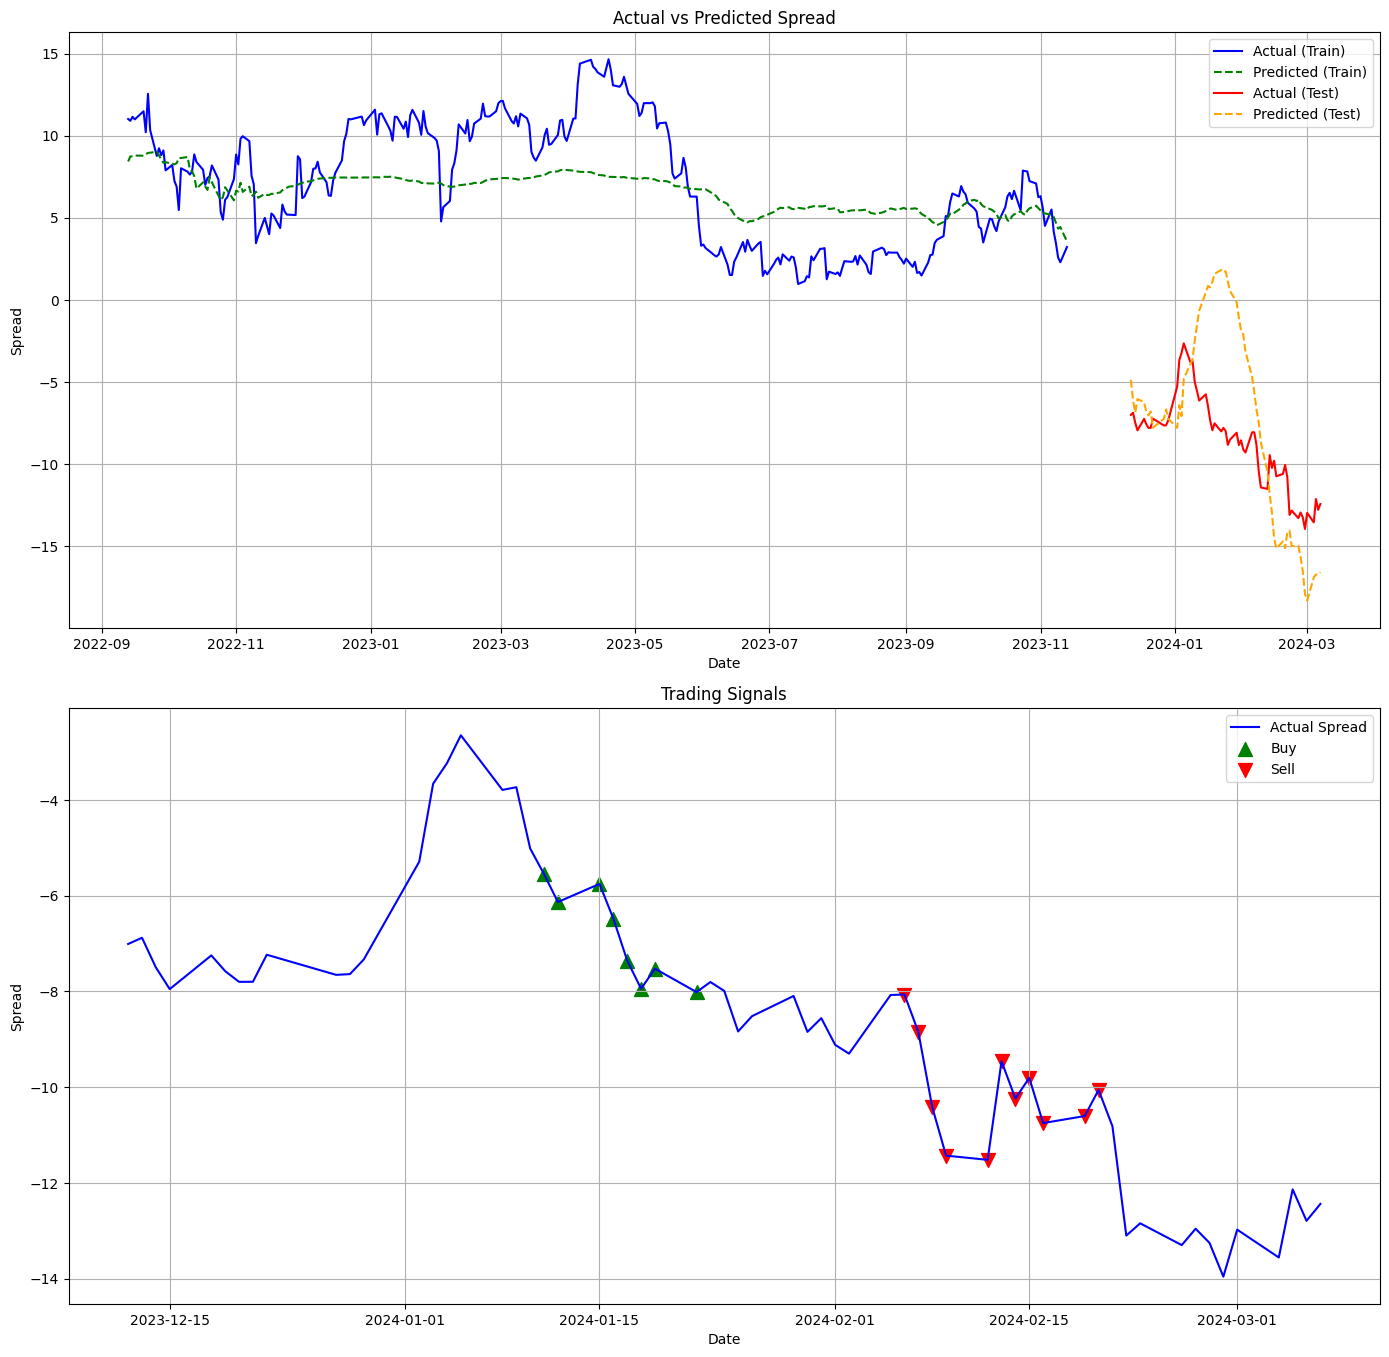

In [146]:
plt.figure(figsize=(14, 20))

plt.subplot(3, 1, 1)

# Plot training data predictions
train_data = all_predictions_df[all_predictions_df['dataset'] == 'train']
plt.plot(train_data.index, train_data['actual_spread'], 
         color='blue', label='Actual (Train)')
plt.plot(train_data.index, train_data['predicted_spread'], 
         color='green', linestyle='--', label='Predicted (Train)')

# Plot test data predictions
test_data = all_predictions_df[all_predictions_df['dataset'] == 'test']
plt.plot(test_data.index, test_data['actual_spread'], 
         color='red', label='Actual (Test)')
plt.plot(test_data.index, test_data['predicted_spread'], 
         color='orange', linestyle='--', label='Predicted (Test)')

plt.title('Actual vs Predicted Spread')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)

# Plot 3: Trading signals
plt.subplot(3, 1, 2)
plt.plot(signals_df['actual_spread'], label='Actual Spread', color='blue')

# Plot buy signals
buy_signals = signals_df[signals_df['signal'] == 1].copy()
if not buy_signals.empty:
    plt.scatter(buy_signals.index, buy_signals['actual_spread'], 
            color='green', marker='^', s=100, label='Buy')

# Plot sell signals
sell_signals = signals_df[signals_df['signal'] == -1].copy()
if not sell_signals.empty:
    plt.scatter(sell_signals.index, sell_signals['actual_spread'], 
            color='red', marker='v', s=100, label='Sell')

plt.title('Trading Signals')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [147]:
#Feature importance
baseline_loss = model.evaluate(X_test, y_test, verbose=0)
importance_scores = []

for i in range(X_test.shape[2]):
    X_test_permuted = X_test.copy()
    X_test_permuted[:, :, i] = np.random.permutation(X_test_permuted[:, :, i])
    
    permuted_loss = model.evaluate(X_test_permuted, y_test, verbose=0)
    importance = permuted_loss - baseline_loss
    importance_scores.append(importance)

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance_scores
})

importance_df = importance_df.sort_values('Importance', ascending=False)
print(importance_df)

            Feature  Importance
11       spread_ma5    6.109924
13       rsi_spread    1.891595
4                GF    0.649136
8      total_rep_pf    0.399063
2               TNX    0.140795
5               COF    0.132976
6            GBPUSD    0.071423
12      spread_ma20    0.070118
0             SP500    0.057625
1               VIX    0.026553
7           FTSE100    0.008564
3               FVX   -0.010324
9   volatility_ftse   -0.023625
10    volatility_pf   -0.082924


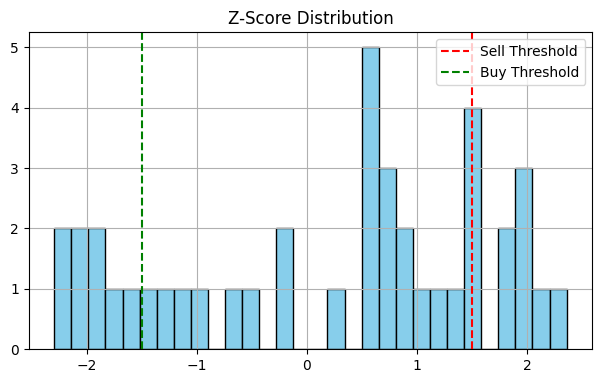

In [148]:
fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(3, 2)

ax1 = fig.add_subplot(gs[2, 0])
ax1.hist(signals_df['z_score'].dropna(), bins=30, color='skyblue', edgecolor='black')
ax1.axvline(x=1.5, color='red', linestyle='--', label='Sell Threshold')
ax1.axvline(x=-1.5, color='green', linestyle='--', label='Buy Threshold')
ax1.set_title('Z-Score Distribution')
ax1.legend()
ax1.grid(True)

In [149]:
# indicator = 'VIX' 
# plt.scatter(merged_df[indicator], merged_df['spread'], alpha=0.5)
# plt.title(f'Spread vs {indicator}')
# plt.xlabel(indicator)
# plt.ylabel('Spread')
# plt.grid(True)


In [150]:

!pip install shap


[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [151]:
# import shap

# masker = shap.maskers.Independent(X_test)  
# explainer = shap.Explainer(model, masker)  
# shap_values = explainer(X_test,max_evals='auto')

# shap.summary_plot(shap_values, features=features)


In [152]:
# !pip install keras_tuner

def get_tuned_lstm(hp):  # Accept hp as an argument
    n_features = X_train.shape[2]
    
    model = Sequential()
    
    # Use hyperparameters for tuning the LSTM layers
    model.add(LSTM(
        hp.Int('units_1', min_value=10, max_value=150, step=20),
        activation='relu', 
        return_sequences=True, 
        input_shape=(X_train.shape[1], n_features)
    ))
    model.add(Dropout(0.2))

    model.add(LSTM(
        hp.Int('units_2', min_value=10, max_value=100, step=20),
        activation='relu'
    ))
    model.add(Dropout(0.2))

    model.add(Dense(1))

    # Use hyperparameter for learning rate tuning
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='mse'
    )
    
    return model


In [153]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    get_tuned_lstm, 
    objective='val_loss',  
    max_trials=10,         
    executions_per_trial=1, 
    directory='my_dir',    
    project_name='lstm_tuning' 
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))



Reloading Tuner from my_dir/lstm_tuning/tuner0.json


In [154]:
best_trial = tuner.oracle.get_best_trials()[0]
best_hyperparameters = best_trial.hyperparameters.values
best_hyperparameters

{'units_1': 70, 'units_2': 10, 'lr': 0.0007137529754858269}

In [ ]:
import joblib

model.save("hackathon_attendance_model.h5")
joblib.dump(scaler, "scaler.pkl")